# Análise dos Modelos Baseline (dataset atualizado)
Replica o protocolo do relatório com walk-forward, busca de sazonalidade do Seasonal Naive e inspeção gráfica de resíduos para o `volume` no dataset novo.

## 1. Procedimento de Validação: Walk-Forward
O método de avaliação *walk-forward* mantém a ordem temporal e atualiza o modelo a cada passo, evitando vazamento de informação. Em cada iteração:
- Ajusta o modelo com todos os dados até a semana `t`.
- Faz previsão genuinamente fora da amostra para as próximas `H` semanas.
- Incorpora o valor real e avança a janela, permitindo acompanhar estabilidade temporal e simular uso em produção.

In [28]:
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf

warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8")
sns.set_palette("colorblind")

HORIZON = 4          # semanas à frente
INITIAL_TRAIN = 52   # uma janela inicial (~1 ano)
SEASONALITY = 52     # sazonalidade semanal padrão

## 2. Carregar dados (volume)
Consideramos apenas `volume` para replicar a análise baseline do relatório anterior.

In [29]:
DATA_PATH = Path("data_updated.csv")
df = pd.read_csv(DATA_PATH)
df["week"] = pd.to_datetime(df["week"])
df = df.sort_values("week").set_index("week")
df["volume"] = df["volume"].astype(float)

print(df.info())
display(df.head())
display(df[["volume"]].describe().T)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 157 entries, 2022-10-31 to 2025-10-27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   volume  157 non-null    float64
 1   inv     157 non-null    float64
 2   users   157 non-null    float64
dtypes: float64(3)
memory usage: 4.9 KB
None


,volume,inv,users
week,,,
2022-10-31,0.38,1.609882,6.500
2022-11-07,0.47,1.880548,7.061
2022-11-14,0.32,2.297810,5.875
2022-11-21,1.69,5.623875,24.238
2022-11-28,1.23,1.473418,7.648


,count,mean,std,min,25%,50%,75%,max
volume,157.0,4.820382,5.162304,0.14,0.66,3.25,7.55,24.52


## 3. Funções auxiliares e métricas
Inclui o *walk-forward*, as funções dos baselines e agregadores de métricas (R², MAE, MSE, RMSE e média dos resíduos).

In [30]:
def walk_forward(df, target_col, model_func, model_kwargs=None, initial_train_size=INITIAL_TRAIN, horizon=HORIZON):
    '''Executa walk-forward com janela crescente.'''
    model_kwargs = model_kwargs or {}
    records = []
    n = len(df)
    for cutoff in range(initial_train_size, n - horizon + 1):
        train = df.iloc[:cutoff]
        test = df.iloc[cutoff : cutoff + horizon]

        preds = np.asarray(model_func(train, test, target_col, horizon, **model_kwargs))
        truth = test[target_col].values

        for h, (y_true, y_pred) in enumerate(zip(truth, preds), start=1):
            records.append(
                {
                    "cutoff": train.index[-1],
                    "horizon": h,
                    "y_true": y_true,
                    "y_pred": y_pred,
                    "residual": y_true - y_pred,
                }
            )

    return pd.DataFrame(records)


def aggregate_metrics(res_df):
    y_true = res_df["y_true"].values
    y_pred = res_df["y_pred"].values
    residual = y_true - y_pred
    mae = np.mean(np.abs(residual))
    mse = np.mean(residual**2)
    rmse = np.sqrt(mse)
    ss_res = np.sum(residual**2)
    ss_tot = np.sum((y_true - y_true.mean())**2)
    r2 = 1 - ss_res / ss_tot if ss_tot > 0 else np.nan
    return {
        "R2": r2,
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "Media dos Residuos": residual.mean(),
    }


def naive_last(train_df, test_df, target_col, horizon, **kwargs):
    last_val = train_df[target_col].iloc[-1]
    return np.repeat(last_val, horizon)


def seasonal_naive(train_df, test_df, target_col, horizon, s=SEASONALITY, **kwargs):
    series = train_df[target_col].values
    if len(series) < s:
        return naive_last(train_df, test_df, target_col, horizon)
    tail = series[-s:]
    reps = int(np.ceil(horizon / s))
    return np.tile(tail, reps)[:horizon]


def mean_history(train_df, test_df, target_col, horizon, **kwargs):
    mean_val = train_df[target_col].mean()
    return np.repeat(mean_val, horizon)


def drift(train_df, test_df, target_col, horizon, **kwargs):
    series = train_df[target_col].values
    if len(series) < 2:
        return naive_last(train_df, test_df, target_col, horizon)
    slope = (series[-1] - series[0]) / (len(series) - 1)
    base = series[-1]
    return np.array([base + slope * h for h in range(1, horizon + 1)])

## 4. Grid Search da Sazonalidade (Seasonal Naive)
Busca o melhor `s` (1 a 160) minimizando o MSE médio das previsões fora da amostra.

Grid sazonalidade: 100%|██████████| 160/160 [00:01<00:00, 151.39it/s]


Melhor sazonalidade: s=1 | MSE=3.5264


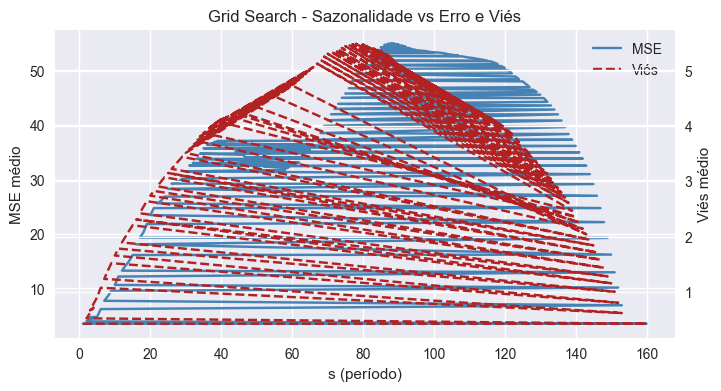

In [31]:
from tqdm.auto import tqdm

s_candidates = list(range(1, 161))

def grid_search_s(df, target_col, s_list):
    rows = []
    for s in tqdm(s_list, desc="Grid sazonalidade"):
        res = walk_forward(df, target_col, seasonal_naive, {"s": s})
        mse = np.mean((res["y_true"] - res["y_pred"]) ** 2)
        bias = (res["y_true"] - res["y_pred"]).mean()
        rows.append({"s": s, "MSE": mse, "Bias": bias})
    grid_df = pd.DataFrame(rows).sort_values("MSE")
    best_s = int(grid_df.iloc[0]["s"])
    return grid_df, best_s

grid_df, best_s = grid_search_s(df[["volume"]], "volume", s_candidates)
print(f"Melhor sazonalidade: s={best_s} | MSE={grid_df.iloc[0]['MSE']:.4f}")

fig, ax1 = plt.subplots(figsize=(8, 4))
ax2 = ax1.twinx()
ax1.plot(grid_df["s"], grid_df["MSE"], color="steelblue", label="MSE")
ax2.plot(grid_df["s"], grid_df["Bias"], color="firebrick", linestyle="--", label="Viés")
ax1.set_xlabel("s (período)")
ax1.set_ylabel("MSE médio")
ax2.set_ylabel("Viés médio")
ax1.set_title("Grid Search - Sazonalidade vs Erro e Viés")

handles, labels = [], []
for ax in [ax1, ax2]:
    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)
ax1.legend(handles, labels, loc="upper right")
Path("imgs").mkdir(exist_ok=True)
fig.savefig("imgs/grid_search_seasonality.png", dpi=200, bbox_inches="tight")
plt.show()

## 5. Avaliação dos Baselines (Naive, Seasonal Naive, Mean, Drift)
Usa o `s` ótimo encontrado e calcula métricas agregadas nas predições walk-forward.

In [32]:
baseline_configs = {
    "Naive": (naive_last, {}),
    "Seasonal Naive": (seasonal_naive, {"s": best_s}),
    "Mean": (mean_history, {}),
    "Drift": (drift, {}),
}

res_by_model = {}
summary_rows = []
for name, (func, kwargs) in baseline_configs.items():
    res = walk_forward(df[["volume"]], "volume", func, kwargs)
    res_by_model[name] = res
    metrics = aggregate_metrics(res)
    summary_rows.append({"Modelo": name, **metrics})

summary_df = pd.DataFrame(summary_rows).set_index("Modelo")
summary_df[["R2", "MAE", "MSE", "RMSE", "Media dos Residuos"]]

,R2,MAE,MSE,RMSE,Media dos Residuos
Modelo,,,,,
Naive,0.849886,1.330956,3.526443,1.877883,0.431838
Seasonal Naive,0.849886,1.330956,3.526443,1.877883,0.431838
Mean,-0.603601,4.651042,37.671449,6.137707,4.648174
Drift,0.853469,1.327347,3.442281,1.855339,0.299659


## 6. Análise Gráfica dos Resíduos (h=1)
Função de autocorrelação (ACF) e distribuição dos resíduos para cada baseline.

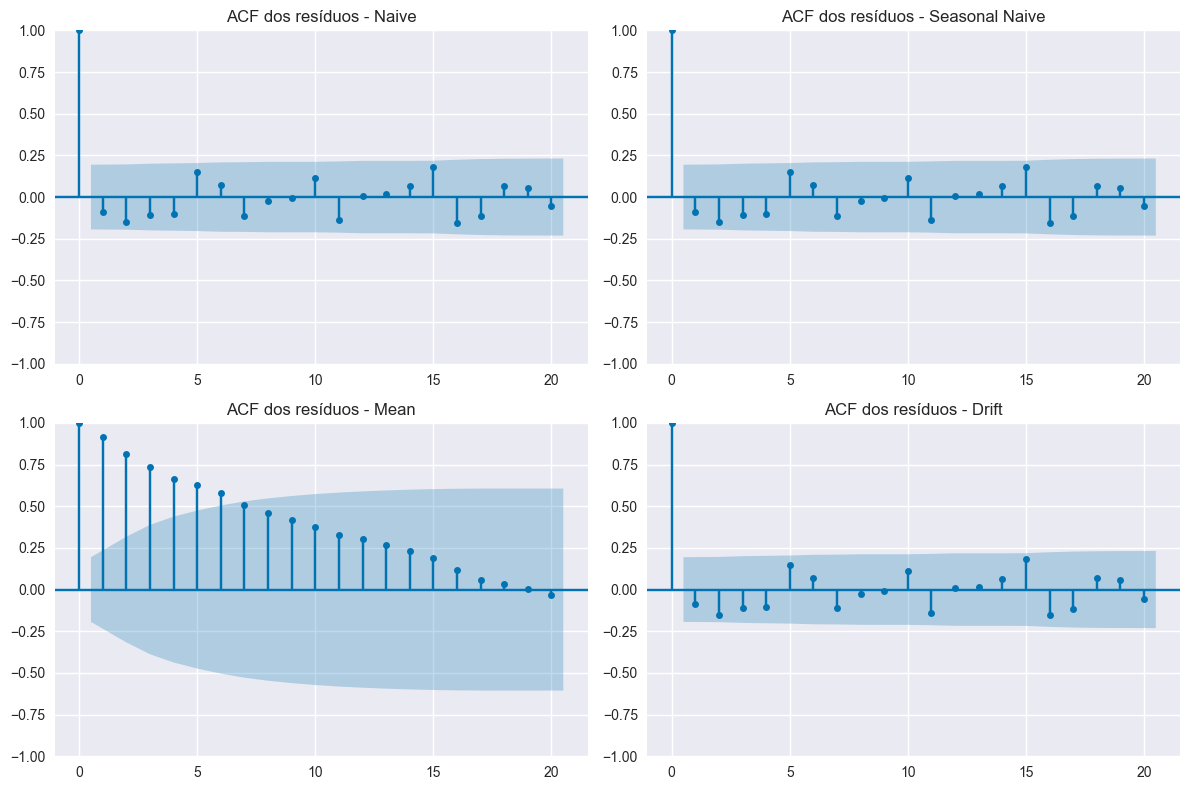

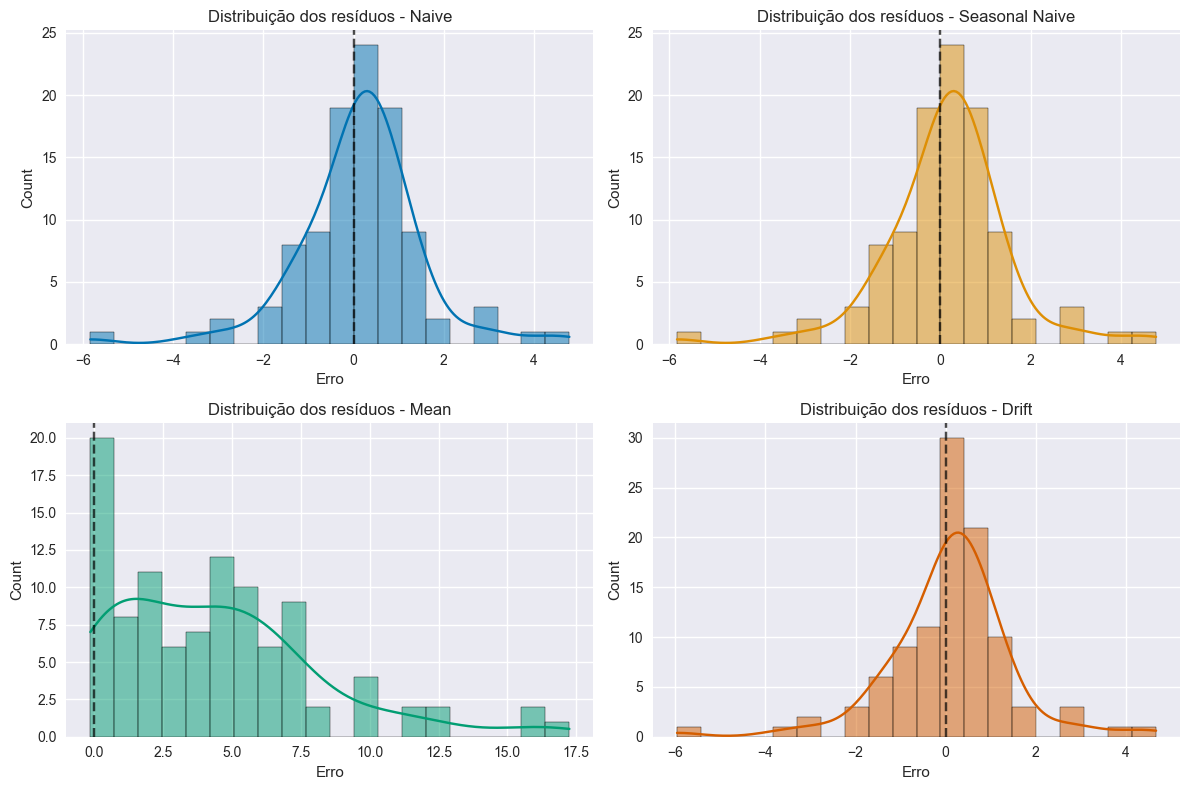

In [33]:
res_h1 = {name: res[res["horizon"] == 1].copy() for name, res in res_by_model.items()}
palette = sns.color_palette("colorblind", n_colors=len(res_h1))

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()
for ax, (name, res) in zip(axes, res_h1.items()):
    if len(res) > 1:
        plot_acf(res["residual"], ax=ax, lags=min(20, len(res) - 1))
    ax.set_title(f"ACF dos resíduos - {name}")
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()
for ax, (name, res), color in zip(axes, res_h1.items(), palette):
    sns.histplot(res["residual"], bins=20, kde=True, ax=ax, color=color)
    ax.axvline(0, color="black", linestyle="--", alpha=0.7)
    ax.set_title(f"Distribuição dos resíduos - {name}")
    ax.set_xlabel("Erro")
plt.tight_layout()
plt.show()

## 7. Síntese Quantitativa e Conclusão
Seleciona o melhor baseline (menor RMSE) e sumariza os achados em linha com o relatório.

In [34]:
best_model = summary_df["RMSE"].idxmin()
print(f"Melhor baseline pelo RMSE: {best_model}")
display(summary_df)

# Síntese textual curta
conclusions = []
conclusions.append(f"Seasonal Naive usa s={best_s} (grid search).")
conclusions.append(f"Melhor baseline: {best_model} (RMSE={summary_df.loc[best_model, 'RMSE']:.4f}).")
conclusions.append("Naive e Drift tendem a resíduos mais centrados em zero; Mean mostra viés maior se a série sobe/descai.")
conclusions.append("ACFs próximas de zero sugerem resíduos próximos de ruído branco para os melhores baselines.")
for c in conclusions:
    print("- ", c)

Melhor baseline pelo RMSE: Drift


,R2,MAE,MSE,RMSE,Media dos Residuos
Modelo,,,,,
Naive,0.849886,1.330956,3.526443,1.877883,0.431838
Seasonal Naive,0.849886,1.330956,3.526443,1.877883,0.431838
Mean,-0.603601,4.651042,37.671449,6.137707,4.648174
Drift,0.853469,1.327347,3.442281,1.855339,0.299659


-  Seasonal Naive usa s=1 (grid search).
-  Melhor baseline: Drift (RMSE=1.8553).
-  Naive e Drift tendem a resíduos mais centrados em zero; Mean mostra viés maior se a série sobe/descai.
-  ACFs próximas de zero sugerem resíduos próximos de ruído branco para os melhores baselines.
